__Purpose:__ Before implementing Federated Learning, re-implement the original simulatinos on the continuous data task we've been working off of to ensure that we implement the correct loss functions in the federated learning task. Simulated decoders should match the decoders found in Ws_block1 from the CPHS data pickle file.
<br>
1. The dec matrix is the weights to pass back and forth, although it comes out of SmoothBatch first
1. We are assuming we can test on the second half (updates 10-19ish) since learning should be complete by then!
1. Scipy.optimize.minimize() runs many iters to fully minimize its cost function.  You can change it to run as many iters as you'd like, although AFAIK you won't know how many it takes to converge.  But this is still a good set up for FL.
1. Hmm minimize() is doing BFGS rn and not SGD... not sure if that matters really.  Could probably implement SGD on my own or find it.  BFGS is 2nd order but we don't have a lot of parameters, I don't think.  Plus we can (already have?) solved analytically for the Hessian.  I think.

In [1]:
import pandas as pd
import os
import numpy as np
np.random.seed(0)
import random
random.seed(0)
from matplotlib import pyplot as plt
from scipy.optimize import minimize, least_squares
import copy
from itertools import permutations

from experiment_params import *
from cost_funcs import *
import time
import pickle

from sklearn.decomposition import PCA

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Reminder of Conditions Order

NOTE: 

* **CONDITIONS** = array(['D_1', 'D_2', 'D_5', 'D_6', 'D_3', 'D_4', 'D_7','D_8']
* **LEARNING RATES:** alpha = 0.25 and 0.75; alpha = 0.25 for D1, D2, D5, D6; alpha = 0.75 for D3, D4, D7, D8
* **SMOOTHBATCH:** W_next = alpha*W_old + ((1 - alpha) * W_calc)

* **DECODER INIT:** pos for D1 - D4, neg for D5 - D8

* **PENALTY TERM:** $\lambda_E$ = 1e-6 for all, $\lambda_F$ = 1e-7 for all, $\lambda_D$ = 1e-3 for 1, 3, 5, 7 and 1e-4 for 2, 4, 6, 8 


| DECODER | ALPHA | PENALTY | DEC INIT |
| --- | --- | --- | --- |
| 1 | 0.25 | 1e-3 | + |
| 2 | 0.25 | 1e-4 | + |
| 3 | 0.75 | 1e-3 | + |
| 4 | 0.75 | 1e-4 | + |
| 5 | 0.25 | 1e-3 | - |
| 6 | 0.25 | 1e-4 | - |
| 7 | 0.75 | 1e-3 | - |
| 8 | 0.75 | 1e-4 | - |


## Load Our Data In

In [3]:
t0 = time.time()

full_data_path = 'C:\\Users\\kdmen\\Desktop\\Research\\Data\\continuous_full_data_block1.pickle'
with open(full_data_path, 'rb') as handle:
    #refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)
    refs_block1, _, _, _, emgs_block1, Ws_block1, _, _, _, _, _ = pickle.load(handle)

#with open('Data\continuous_full_data_block2.pickle', 'rb') as handle:
    #refs_block2, poss_block2, dec_vels_block2, int_vel_block2, emgs_block2, Ws_block2, Hs_block2, alphas_block2, pDs_block2, times_block2, conditions_block2 = pickle.load(handle)
    #refs_block2, _, _, _, emgs_block2, Ws_block2, _, _, _, _, _ = pickle.load(handle)

t1 = time.time()
total = t1-t0  
print(total)

5.717322826385498


## CPHS Code
> Not sure why the results are the way they are...

In [4]:
# For condition 1:
alpha = .25 # higher alpha means more old decoder (slower update)
# Assuming these are the same as lambda's, the decoder cost penalties
alphaD = 1e-3
#where is lambda E?

# Setting alphaF to 0 to allow us to directly compare cost funcs
#alphaF = 1e-7
alphaF = 0

In [5]:
D_0 = np.random.rand(2,64)
D_0_10 = np.random.rand(2,10)
PCA_comps = 10
pca_channel_default = 64

Condition 0 only for now

In [6]:
first_half = 14  # Used to be 7, idk why I only wanted to use half

#def simulation(D,learning_batch,alpha,alphaF=1e-2,alphaD=1e-2,display_info=False,num_iters=False):
display_info=False
total_num_updates = 19
final_training_update = 15
starting_update = 0 # This is not used anywhere else except directly below FYI 
num_updates = final_training_update - starting_update
dt = 1/60

D = [[0 for _ in range(num_updates)] for i in range(first_half)]
cost_log = [[0 for _ in range(num_updates)] for i in range(first_half)]
grad_cost_log = [[0 for _ in range(num_updates)] for i in range(first_half)]
performance_log = [[0 for _ in range(num_updates)] for i in range(first_half)]
Dnorm_log = [[0 for _ in range(num_updates)] for i in range(first_half)]
#Fnorm_log = [[0 for _ in range(num_updates)] for i in range(first_half)]

test_cost_log = [[0 for _ in range(num_updates)] for i in range(first_half)]
test_cost_log_postSB = [[0 for _ in range(num_updates)] for i in range(first_half)]
s_test_log = [0]*first_half
F_test_log = [0]*first_half
p_test_reference_log = [0]*first_half

# All clients share the same bounds
test_lower_bound = (update_ix[final_training_update+1])#//2  #Use only the second half of each update
test_upper_bound = update_ix[final_training_update+2]
test_learning_batch = test_upper_bound - test_lower_bound

for idx, user in enumerate(keys[:first_half]):
    filtered_signals = emgs_block1[user][0,:,:]
    p_reference_full = refs_block1[user][0,:,:]
    #D[idx][0] = Ws_block1[user][0,0,:,:]
    if PCA_comps!=pca_channel_default:  
        D[idx][0] = D_0_10
    else:
        D[idx][0] = D_0
    total_datapoints = emgs_block1[user][0,:,:].shape[0]
    
    # TESTING LOG
    # Each client will have their own testing data (only needs to be set once)
    s_test = np.transpose(filtered_signals[test_lower_bound:test_upper_bound,:])
    s_test = s_test/np.amax(s_test)
    #s_test = np.transpose(s_test)
    if PCA_comps!=pca_channel_default:  
        pca = PCA(n_components=PCA_comps)
        s_test = np.transpose(pca.fit_transform(np.transpose(s_test)))
    s_test_log[idx] = s_test
    F_test_log[idx] = s_test_log[idx][:,:-1] # note: truncate F for estimate_decoder
    p_test_reference_log[idx] = np.transpose(p_reference_full[test_lower_bound:test_upper_bound,:])

    # batches the trials into each of the update batch
    # Do num_updates-1 because the very last update is only 1 datapoint, the 2nd to last is only 337
    for ix in range(final_training_update-1):
        ix+=1  # I think this might make it skip the 1st update (eg update 0) --> I changed it to ix-1, ix
        # Reason is because it lets us do D[idx][ix-1] to get the init dec
        #print(ix)

        # Instead of using learning_batch, we should get the same results just using update_ix values
        if ix==(final_training_update):
            upper_bound = total_datapoints
        else:
            upper_bound = update_ix[ix]
        #lower_bound = (upper_bound-update_ix[ix-1])//2
        #^This is what it ought to be but signal blows up for some reason
        lower_bound = update_ix[ix-1]
        learning_batch = upper_bound - lower_bound

        #s = np.transpose(filtered_signals[lower_bound:upper_bound,:])
        s = filtered_signals[lower_bound:upper_bound,:]
        s_normed = s/np.amax(s)
        s = np.transpose(s_normed)
        if PCA_comps!=pca_channel_default:  
            pca = PCA(n_components=PCA_comps)
            s = np.transpose(pca.fit_transform(np.transpose(s)))
        
        v_actual = D[idx][ix-1]@s
        # Numerical integration of v_actual to get p_actual
        p_actual = np.cumsum(v_actual, axis=1)*dt
        # Update decoder
        p_reference = np.transpose(p_reference_full[lower_bound:upper_bound,:])
        #(r-y)/60=D_new@s  # This is the optimization problem
        V = (p_reference - p_actual)*dt
        F = copy.deepcopy(s[:,:-1]) # note: truncate F for estimate_decoder

        # set alphas
        H = np.zeros((2,2))
        # use scipy minimize for gradient descent and provide pre-computed analytical gradient for speed
        # Is using D[-1] the same as solving the lambda min D function?
        cost_log[idx][ix] = cost_l2(F,D[idx][ix-1],H,V,learning_batch,alphaF,alphaD,Ne=PCA_comps)
        grad_cost_log[idx][ix] = gradient_cost_l2(F,D[idx][ix-1],H,V,learning_batch,alphaF,alphaD,Ne=PCA_comps)
        out = minimize(lambda D: cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=PCA_comps), D[idx][ix-1], method='BFGS', jac=lambda D: gradient_cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=PCA_comps), options={'disp': display_info})

        performance_log[idx][ix] = (1e-6)*(np.linalg.norm((D[idx][ix-1]@F + H@V[:,:-1] - V[:,1:]))**2)
        Dnorm_log[idx][ix] = alphaD*(np.linalg.norm(D[idx][ix-1])**2)
        
        # reshape to decoder parameters
        W_hat = np.reshape(out.x,(2, PCA_comps))
        
        # TESTING LOG
        model = W_hat
        v_actual = model@s_test_log[idx]
        p_actual = np.cumsum(v_actual, axis=1)*dt  # Numerical integration of v_actual to get p_actual
        V_test = (p_test_reference_log[idx] - p_actual)*dt
        test_cost_log[idx][ix] = cost_l2(F_test_log[idx],model,H,V_test,test_learning_batch,alphaF,alphaD,Ne=PCA_comps)

        # DO SMOOTHBATCH
        W_new = alpha*D[idx][ix-1] + ((1 - alpha) * W_hat)
        D[idx][ix] = W_new

        model = D[idx][ix]
        v_actual = model@s_test_log[idx]
        p_actual = np.cumsum(v_actual, axis=1)*dt  # Numerical integration of v_actual to get p_actual
        V_test = (p_test_reference_log[idx] - p_actual)*dt
        test_cost_log_postSB[idx][ix] = cost_l2(F_test_log[idx],model,H,V_test,test_learning_batch,alphaF,alphaD,Ne=PCA_comps)

In [7]:
print(D[idx][ix-1].shape)
print(s.shape)

(2, 10)
(10, 1202)


In [8]:
s_test.shape

(10, 1202)

In [9]:
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}

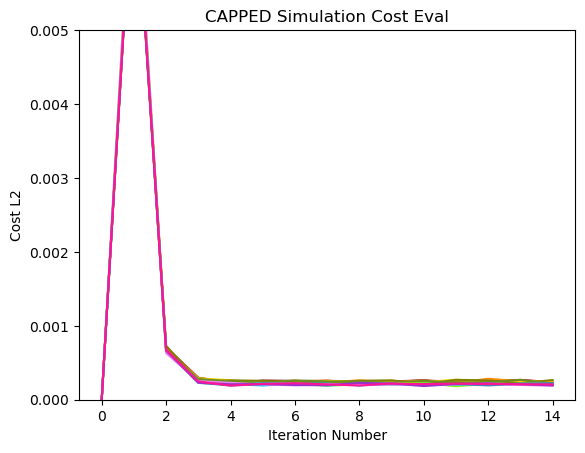

In [10]:
step_indices = list(range(num_updates))
for i in range(first_half):
    plt.plot(step_indices, cost_log[i], color=id2color[i])
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('CAPPED Simulation Cost Eval')
plt.ylim(0, 0.005)
plt.show()

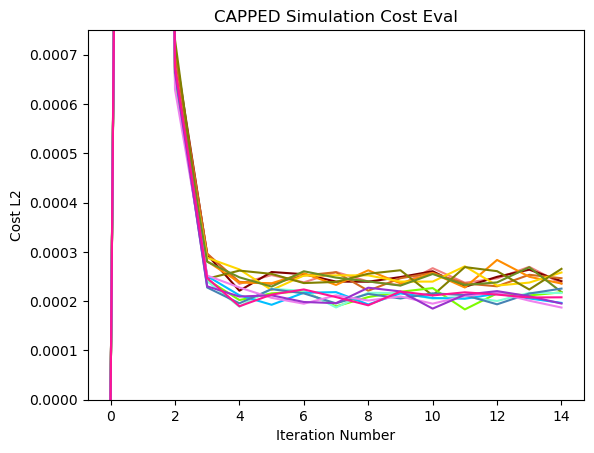

In [11]:
step_indices = list(range(num_updates))
for i in range(first_half):
    plt.plot(step_indices, cost_log[i], color=id2color[i])
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('CAPPED Simulation Cost Eval')
plt.ylim(0, 0.00075)
plt.show()

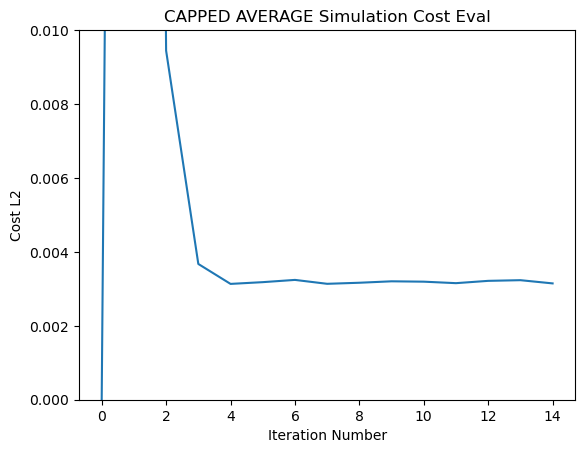

In [12]:
step_indices = list(range(num_updates))
avg_cost_npy = np.zeros(num_updates)
for i in range(first_half):
    avg_cost_npy += np.array(cost_log[i])
plt.plot(step_indices, avg_cost_npy)
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('CAPPED AVERAGE Simulation Cost Eval')
plt.ylim(0, 0.01)
plt.show()

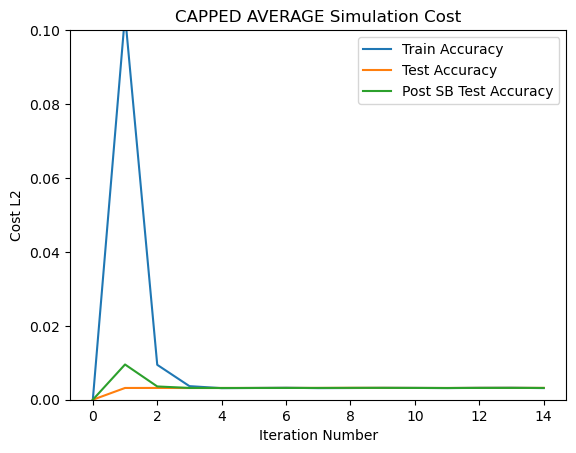

In [13]:
step_indices = list(range(num_updates))
avg_train_cost_npy = np.zeros(num_updates)
avg_test_cost_npy = np.zeros(num_updates)
avg_testSB_cost_npy = np.zeros(num_updates)
for i in range(first_half):
    avg_train_cost_npy += np.array(cost_log[i])
    avg_test_cost_npy += np.array(test_cost_log[i])
    avg_testSB_cost_npy += np.array(test_cost_log_postSB[i])
plt.plot(step_indices, avg_cost_npy, label="Train Accuracy")
plt.plot(step_indices, avg_test_cost_npy, label="Test Accuracy")
plt.plot(step_indices, avg_testSB_cost_npy, label="Post SB Test Accuracy")
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('CAPPED AVERAGE Simulation Cost')
plt.ylim(0, 0.1)
plt.legend()
plt.show()

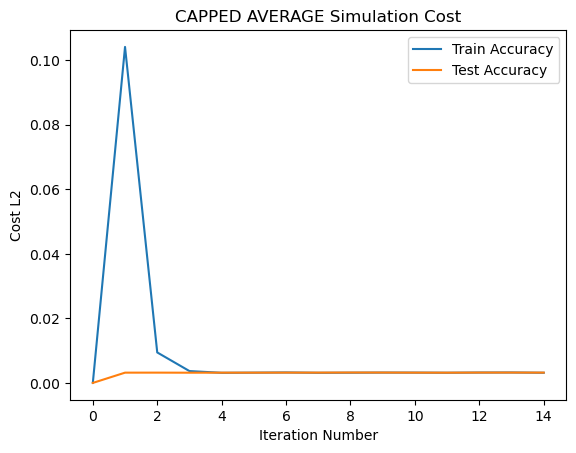

In [14]:
step_indices = list(range(num_updates))
avg_train_cost_npy = np.zeros(num_updates)
avg_test_cost_npy = np.zeros(num_updates)
avg_testSB_cost_npy = np.zeros(num_updates)
for i in range(first_half):
    avg_train_cost_npy += np.array(cost_log[i])
    avg_test_cost_npy += np.array(test_cost_log[i])
    avg_testSB_cost_npy += np.array(test_cost_log_postSB[i])
plt.plot(step_indices, avg_cost_npy, label="Train Accuracy")
plt.plot(step_indices, avg_test_cost_npy, label="Test Accuracy")
#plt.plot(step_indices, avg_testSB_cost_npy, label="Post SB Test Accuracy")
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('CAPPED AVERAGE Simulation Cost')
plt.legend()
plt.show()

# Recreating Using fl_sim Code
## Nonzero random inits

In [15]:
from fl_sim_client import *
from fl_sim_server import *

path = r'C:\Users\kdmen\Desktop\Research\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'

with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)
    
with open(path+all_decs_init_filename, 'rb') as fp:
    init_decoders = pickle.load(fp)
cond0_init_decs = [dec[0, :, :] for dec in init_decoders]
D_0 = np.random.rand(2,64)

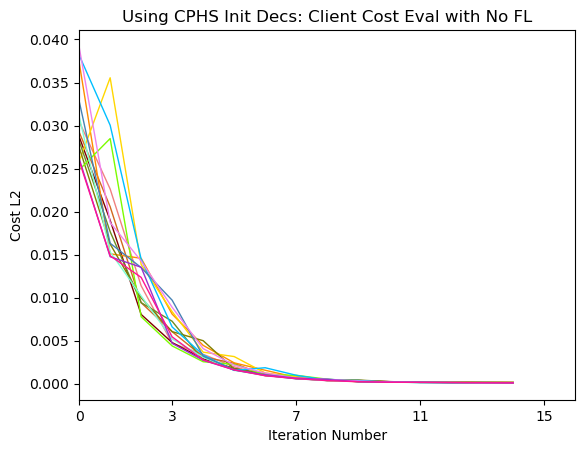

In [16]:
user_df = [Client(i, D_0, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', set_alphaF_zero=True, track_cost_components=True, normalize_EMG=True, PCA_comps=64, delay_scaling=0) for i in range(14)]
server_df = Server(-1, D_0, 'NoFL', user_df, PCA_comps=64)

num_updates_left = 15
for i in range(num_updates_left):
    server_df.execute_FL_loop()
    
condensed_external_plotting(user_df, 'local', global_error=False, dim_reduc_factor=1, show_update_change=False, custom_title='Using CPHS Init Decs: Client Cost Eval with No FL')

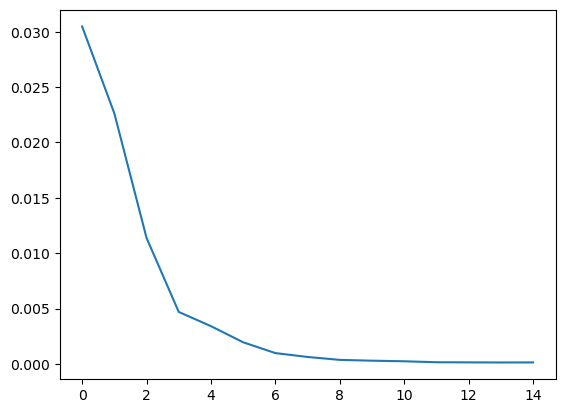

In [17]:
plt.plot(user_df[0].local_error_log)

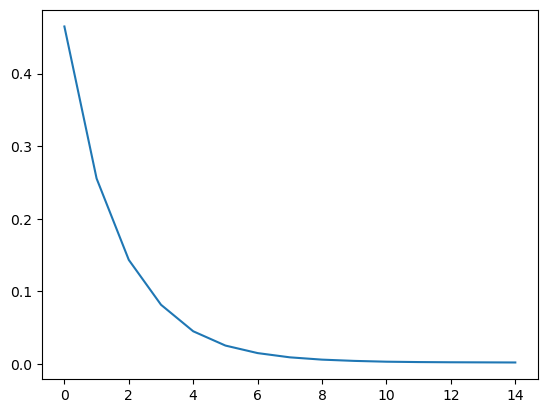

In [18]:
plt.plot(user_df[0].local_test_error_log)

## CPHS Inits
> Interesting that CPHS is the only one that is completely flat and apparently broken...

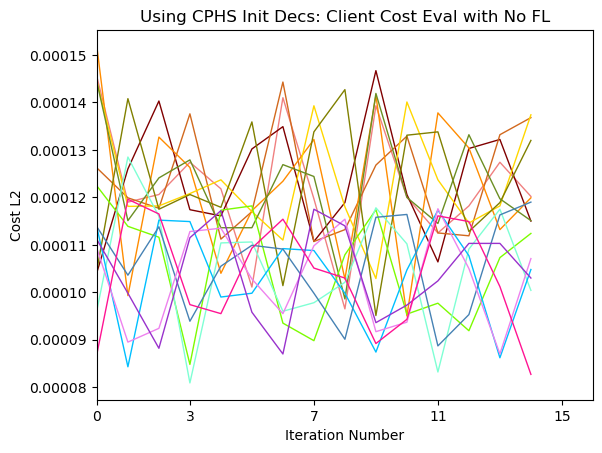

In [19]:
user_df = [Client(i, cond0_init_decs[i], 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', set_alphaF_zero=True, track_cost_components=True, normalize_EMG=True, PCA_comps=64, delay_scaling=0) for i in range(14)]
server_df = Server(-1, D_0, 'NoFL', user_df, PCA_comps=64)

num_updates_left = 15
for i in range(num_updates_left):
    server_df.execute_FL_loop()
    
condensed_external_plotting(user_df, 'local', global_error=False, dim_reduc_factor=1, show_update_change=False, custom_title='Using CPHS Init Decs: Client Cost Eval with No FL')

## Not-Shared Random Inits

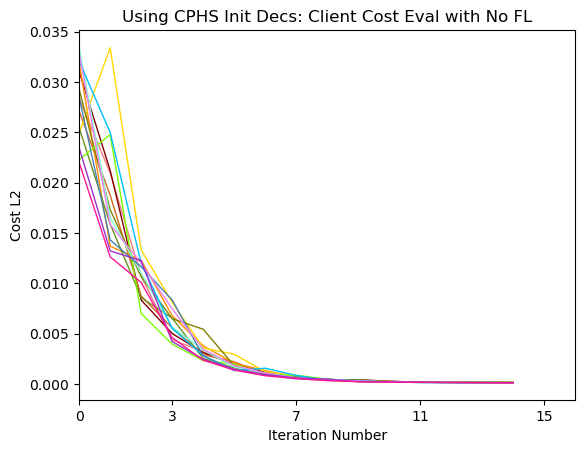

In [20]:
my_seed = 100
np.random.seed(my_seed)
random.seed(my_seed)

user_df = [Client(i, np.random.rand(2,64), 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', set_alphaF_zero=True, track_cost_components=True, normalize_EMG=True, PCA_comps=64, delay_scaling=0) for i in range(14)]
server_df = Server(-1, np.random.rand(2,64), 'NoFL', user_df, PCA_comps=64)

num_updates_left = 15
for i in range(num_updates_left):
    server_df.execute_FL_loop()
    
condensed_external_plotting(user_df, 'local', global_error=False, dim_reduc_factor=1, show_update_change=False, custom_title='Using CPHS Init Decs: Client Cost Eval with No FL')

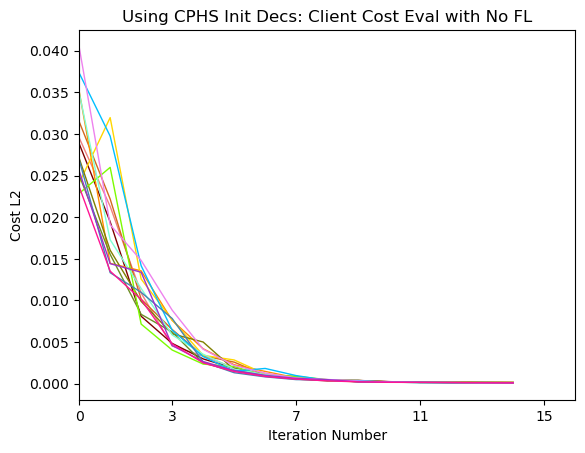

In [21]:
my_seed = 101
np.random.seed(my_seed)
random.seed(my_seed)

user_df = [Client(i, np.random.rand(2,64), 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', set_alphaF_zero=True, track_cost_components=True, normalize_EMG=True, PCA_comps=64, delay_scaling=0) for i in range(14)]
server_df = Server(-1, np.random.rand(2,64), 'NoFL', user_df, PCA_comps=64)

num_updates_left = 15
for i in range(num_updates_left):
    server_df.execute_FL_loop()
    
condensed_external_plotting(user_df, 'local', global_error=False, dim_reduc_factor=1, show_update_change=False, custom_title='Using CPHS Init Decs: Client Cost Eval with No FL')

In [22]:
assert(1==0)

AssertionError: 

# Save Output Data For Plotting In Another NB

In [ ]:
avg_train_cost_df = pd.DataFrame(avg_train_cost_npy)
avg_test_cost_df = pd.DataFrame(avg_test_cost_npy)
avg_testSB_cost_df = pd.DataFrame(avg_testSB_cost_npy)

print(avg_train_cost_df.shape)

In [ ]:
cost_df = pd.DataFrame(cost_log)
test_cost_df = pd.DataFrame(test_cost_log)
test_cost_df_postSB = pd.DataFrame(test_cost_log_postSB)

print(cost_df.shape)

In [ ]:
new_row = avg_train_cost_df.iloc[:].transpose()
cost_df = pd.concat([cost_df, new_row], ignore_index=True)
print("COST DF")
print(cost_df.shape)
cost_df.head()

In [ ]:
new_row = avg_test_cost_df.iloc[:].transpose()
test_cost_df = pd.concat([test_cost_df, new_row], ignore_index=True)
print("TEST COST DF")
print(test_cost_df.shape)
test_cost_df.head()

In [ ]:
new_row = avg_testSB_cost_df.iloc[:].transpose()
test_cost_df_postSB = pd.concat([test_cost_df_postSB, new_row], ignore_index=True)
print("TEST SB COST DF")
print(test_cost_df_postSB.shape)
test_cost_df_postSB.head()

In [ ]:
cost_df.to_csv(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\599_PrivacyAnalysis\Poster_Plotting\200P_train_cost_df.csv")
test_cost_df.to_csv(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\599_PrivacyAnalysis\Poster_Plotting\200P_test_cost_df.csv")
test_cost_df_postSB.to_csv(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\599_PrivacyAnalysis\Poster_Plotting\200P_test_cost_df_postSB.csv")